# 05.10 - Manifold Learning

While PCA is flexible, fast, and easily interpretable, it does not perform so well when there are nonlinear relationships within the data.  

To address this deficiency, we can turn to a class of methods known as **manifold learning** — a class of unsupervised estimators that seeks to _describe datasets as low-dimensional manifolds embedded in high-dimensional spaces_.

In this section, we will explore three particular techniques:

1. Multidimensional Scaling (MDS) 
2. Locally linear embeddings (LLE)
3. Isometric Mapping (IsoMap)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

### Manifold Learning: "HELLO"

Let's start by generating some two-dimensional data that we can use to define a manifold. Here is a function that will create data in the shape of the word "HELLO":

In [2]:
def make_hello(N=1000, rseed=42):
    # Make a plot with "HELLO" text; save as PNG
    fig, ax = plt.subplots(figsize=(4, 1))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axis('off')
    ax.text(0.5, 0.4, 'HELLO', va='center', ha='center', weight='bold', size=85)
    fig.savefig('hello.png')
    plt.close(fig)
    
    # Open this PNG and draw random points from it
    from matplotlib.image import imread
    data = imread('hello.png')[::-1, :, 0].T
    rng = np.random.RandomState(rseed)
    X = rng.rand(4 * N, 2)
    i, j = (X * data.shape).astype(int).T
    mask = (data[i, j] < 1)
    X = X[mask]
    X[:, 0] *= (data.shape[0] / data.shape[1])
    X = X[:N]
    return X[np.argsort(X[:, 0])]

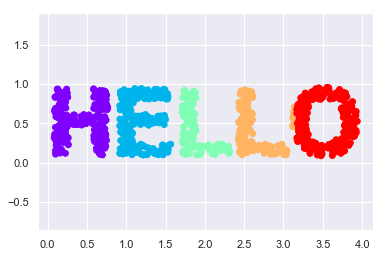

In [3]:
X = make_hello(1000)
colorize = dict(c=X[:, 0], cmap=plt.cm.get_cmap('rainbow', 5))
plt.scatter(X[:, 0], X[:, 1], **colorize)
plt.axis('equal');

### 1. Multidimensional Scaling (MDS)

Looking at data like this, we can see that the particular choice of *x and y values of the dataset are not the most fundamental description of the data*: we can scale, shrink, or rotate the data, and the "HELLO" will still be apparent. 

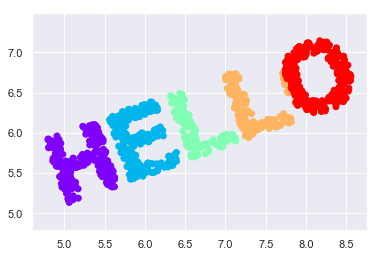

In [4]:
# rotating 'HELLO'
def rotate(X, angle):
    theta = np.deg2rad(angle)
    R = [[np.cos(theta), np.sin(theta)],
         [-np.sin(theta), np.cos(theta)]]
    return np.dot(X, R)
    
X2 = rotate(X, 20) + 5
plt.scatter(X2[:, 0], X2[:, 1], **colorize)
plt.axis('equal');

What is fundamental, in this case, is the _distance between each point and the other points in the dataset_. Using this intuition, we can create a N X N matrix with the distance between any two given points (pairs) in our two-dim graph.

To do this more efficiently, we can use Scikit-learn <code>pairwise_distances</code>:

In [5]:
from sklearn.metrics import pairwise_distances
D = pairwise_distances(X)
D.shape

(1000, 1000)

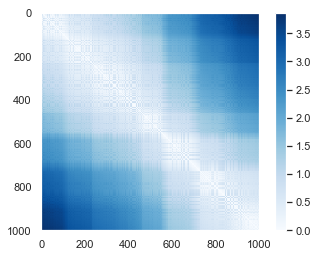

In [6]:
# visualizing distances
plt.imshow(D, zorder=2, cmap='Blues', interpolation='nearest')
plt.colorbar();

In [7]:
# matrix for our rotated image is the same (distances didn't change)
D2 = pairwise_distances(X2)
np.allclose(D, D2)

True

This distance matrix gives us a representation of our data that is invariant to rotations and translations, but we have lost any visible sign of the interesting structure in the data: the "HELLO".  

This is exactly what the multidimensional scaling algorithm aims to do: given a distance matrix between points, it recovers a D-dimensional coordinate representation of the data. 

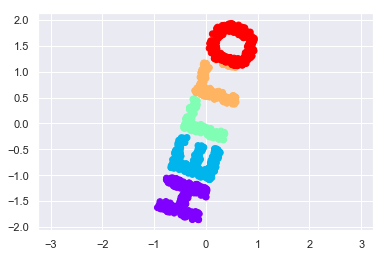

In [8]:
from sklearn.manifold import MDS
model = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
out = model.fit_transform(D)
plt.scatter(out[:, 0], out[:, 1], **colorize)
plt.axis('equal');

### MDS as Manifold Learning

This becomes very useful when we start to deal with _higher_ dimensions:

In [9]:
# generalization of the rotation matrix used earlier
def random_projection(X, dimension=3, rseed=42):
    assert dimension >= X.shape[1]
    rng = np.random.RandomState(rseed)
    C = rng.randn(dimension, dimension)
    e, V = np.linalg.eigh(np.dot(C, C.T))
    return np.dot(X, V[:X.shape[1]])
    
X3 = random_projection(X, 3)
X3.shape

(1000, 3)

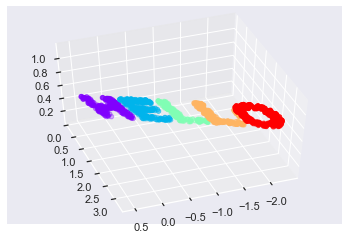

In [10]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter3D(X3[:, 0], X3[:, 1], X3[:, 2],
             **colorize)
ax.view_init(azim=70, elev=50)

We can now ask the <code>MDS</code> estimator to input this three-dimensional data, compute the distance matrix, and then determine the optimal two-dimensional embedding for this distance matrix. 

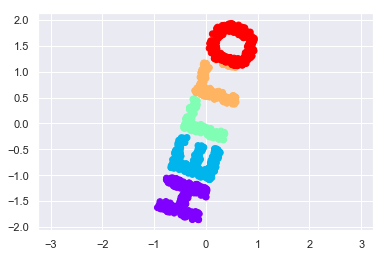

In [11]:
model = MDS(n_components=2, random_state=1)
out3 = model.fit_transform(X3)
plt.scatter(out3[:, 0], out3[:, 1], **colorize)
plt.axis('equal');

This is essentially the goal of a manifold learning estimator: given high-dimensional embedded data, it seeks a low-dimensional representation of the data that preserves certain relationships within the data. In the case of MDS, the quantity preserved is the distance between every pair of points.

### Nonlinear Embeddings: Where MDS Fails

Our discussion thus far has considered linear embeddings, which essentially consist of rotations, translations, and scalings of data into higher-dimensional spaces. 
If we try to do something beyond linear embeddings, MDS is not the most suitable method. 

In [12]:
# make our hello in 'S' shape
def make_hello_s_curve(X):
    t = (X[:, 0] - 2) * 0.75 * np.pi
    x = np.sin(t)
    y = X[:, 1]
    z = np.sign(t) * (np.cos(t) - 1)
    return np.vstack((x, y, z)).T

XS = make_hello_s_curve(X)

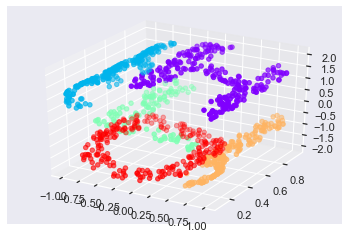

In [13]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter3D(XS[:, 0], XS[:, 1], XS[:, 2],
             **colorize);

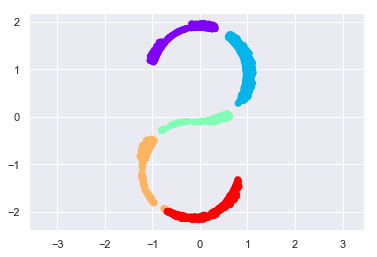

In [14]:
from sklearn.manifold import MDS
model = MDS(n_components=2, random_state=2)
outS = model.fit_transform(XS)
plt.scatter(outS[:, 0], outS[:, 1], **colorize)
plt.axis('equal');

As we can see here, the best linear embedding simply return the original y-axis. 

### Nonlinear Manifolds: Locally Linear Embedding (LLE)

Stepping back, we can see that the source of the problem is that MDS tries to preserve distances between faraway points when constructing the embedding. But what if we instead modified the algorithm such that it only preserves distances between nearby points?

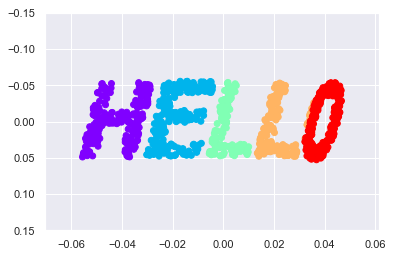

In [15]:
# modified LLE
from sklearn.manifold import LocallyLinearEmbedding
model = LocallyLinearEmbedding(n_neighbors=100, n_components=2, method='modified',
                               eigen_solver='dense')
out = model.fit_transform(XS)

fig, ax = plt.subplots()
ax.scatter(out[:, 0], out[:, 1], **colorize)
ax.set_ylim(0.15, -0.15);

### Consideration on Manifold Learning

Despite its distinctive advantange in preserving nonlinear relationships in the data, Manifold Learning presents some drawbacks:

1. No good framework for **handling missing data**;
2. The presence of **noise** in the data can drastically change the embedding; 
3. Manifold embedding results are generally **dependent on the number of neighbors** chosen, and there is generally _no solid quantitative way to choose an optimal number of neighbors_;
4. The **globally optimal number of output dimensions is difficult to determine**;
5. The models are **not very interpretable**; 
6. **Computational expense** of manifold methods scales as O[N^2] or O[N^3].

### Example: Isomap on Faces

One place manifold learning is often used is in understanding the relationship between high-dimensional data points.  

Here let's apply Isomap on some faces data:

In [16]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=30)
faces.data.shape

(1075, 2914)

One useful way to start is to compute a PCA, and examine the explained variance ratio, which will give us an idea of how many linear features are required to describe the data:

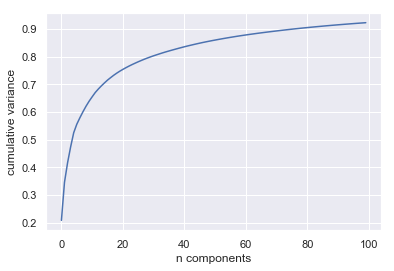

In [18]:
from sklearn.decomposition import PCA
model = PCA(100).fit(faces.data)
plt.plot(np.cumsum(model.explained_variance_ratio_))
plt.xlabel('n components')
plt.ylabel('cumulative variance');

As we can, this data cannot easily be reduced to linearly with a few components. 

In [19]:
# Isomap embedding
from sklearn.manifold import Isomap
model = Isomap(n_components=2)
proj = model.fit_transform(faces.data)
proj.shape

(1075, 2)

In [20]:
# graphical representation with 'thumbnails' for points
from matplotlib import offsetbox

def plot_components(data, model, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()
    
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

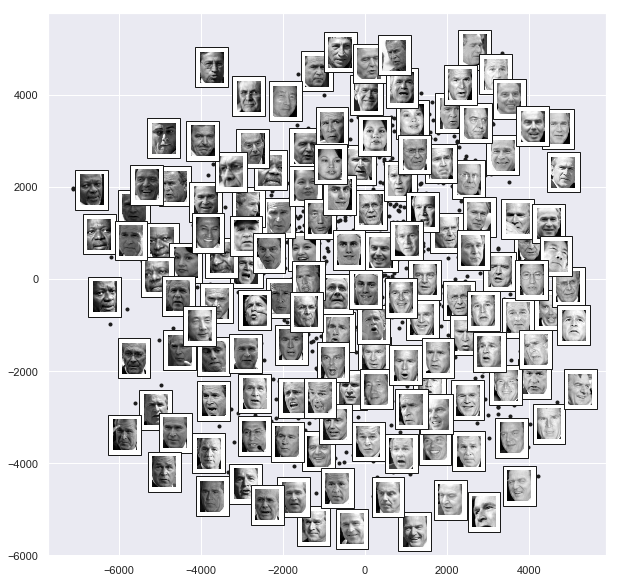

In [21]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_components(faces.data,
                model=Isomap(n_components=2),
                images=faces.images[:, ::2, ::2])